In [1]:
import numpy as np
import numpy.linalg as npla

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300

In [2]:
def sv_lhs (x, x0, roots, exps):
    y = 1.0
    for r,e in zip(roots, exps):
        y *= np.power((x - r)/(x0 - r), e)
    return y
#     y = 0.0
#     for r,e in zip(roots, exps):
#         y += e * np.log((x - r)/(x0 - r))
#     return y

def sv_lhs_deriv (x, x0, roots, exps):
    y = 0.0
    for j in range(len(roots)):
        prod = 1.0
        for i in range(len(roots)):
            if i != j:
                prod *= np.power((x-roots[i])/(x0-roots[i]), 
                                exps[i])
            else:
                prod *= exps[i] * np.power((x - roots[i])/(x0 - roots[i]), 
                                exps[i] - 1.0)
        y += prod
    return y
#     y = 0.0
#     for r,e in zip(roots, exps):
#         y += e * (x0 - r) / (x - r)
#     return y

# def sv_nr_ratio (x, x0, roots, exps, t, alpha):
#     lhs = sv_lhs (x, x0, roots, exps)
#     dlhs = sv_lhs_deriv (x, x0, roots, exps)
#     y = (lhs - np.exp(- alpha * t)) / dlhs
#     # y = (lhs + alpha * t) / dlhs
#     #print(y, lhs, dlhs)
# #     s = 0.0
# #     for r,e in zip(roots, exps):
# #         s += e * (x0 - r)/(x - r)
# #     lhs = sv_lhs (x, x0, roots, exps)
# #     y = (1.0 / s) * (1.0 - np.exp(- alpha * t) / lhs)
# #     print(y, lhs, s)
#     return y

In [3]:
def newton_raphson_poly (p, x_guess, tol=1e-9, max_iter=100):
    pd = np.polyder(p);
    x = x_guess
    for i in range(max_iter):
        err = x
        x = x - np.polyval(p,x) / np.polyval(pd,x)
        err = abs((x - err) / x)
        print("x, err = ", x, err)
        if err < tol:
            break
    
    return x

def bisection_sv (xm, x1, x2, 
                  m0, roots, exps, 
                  t, alpha,
                  counter=0, tol=1e-10, max_iter=1000):
    
    fm = np.real(sv_lhs (xm, m0, roots, exps) - np.exp(- alpha * t))
    f1 = np.real(sv_lhs (x1, m0, roots, exps) - np.exp(- alpha * t))
    f2 = np.real(sv_lhs (x2, m0, roots, exps) - np.exp(- alpha * t))
    
    if np.isnan(f1):
        if 0 < np.real(sv_lhs (x1+tol*(x2-x1), m0, roots, exps) - np.exp(- alpha * t)):
            f1 = float('inf')
        else:
            f1 = -float('inf')
    
    if np.isnan(f2):
        if 0 < np.real(sv_lhs (x2-tol*(x2-x1), m0, roots, exps) - np.exp(- alpha * t)):
            f2 = float('inf')
        else:
            f2 = -float('inf')
    
    # print("function evals", f1, fm, f2)
    
    if counter > max_iter:
        print("Convergence not reached.")
        #return float('nan')
        return 0.0
    
    err = np.abs((x2-x1)/xm)
    #err = np.abs((x2-x1)/xm)
    if err < tol:
        print("num iter = ", counter)
        return xm
    
#     print("bisection step (x, err): ", xm, err)
    
    if np.sign(fm)*np.sign(f1) > 0 \
            and np.sign(fm)*np.sign(f2) > 0:
        print("Error! No zero found.")
        return float('nan')
        #return 0.0
    else:
        if np.sign(fm)*np.sign(f1) > 0:
            x = bisection_sv(0.5*(xm+x2), xm, x2, 
                        m0, roots, exps, t, alpha,
                        counter+1, tol, max_iter)
            return x
        elif np.sign(fm)*np.sign(f2) > 0:
            x = bisection_sv(0.5*(x1+xm), x1, xm, 
                        m0, roots, exps, t, alpha,
                        counter+1, tol, max_iter)
            return x
        else:
            print("Warning! Case not accounted.")
            print("num iter = ", counter)
            #return float('nan')
            return xm

def zero_finder_sv (x_guess, x0, roots, exps, 
                    t, alpha,
                    tol=1e-10, max_iter=1000):
    
    imag_tol = 1.0e-12
    r_sort = []
    for r in roots:
        if np.abs(np.imag(r)) < imag_tol:
            r_sort.append(np.real(r))
    r_sort.sort()
    if x_guess <= r_sort[0]:
        bound_lo, bound_hi = -float('inf'), r_sort[0]
    elif x_guess >= r_sort[-1]:
        bound_lo, bound_hi = r_sort[-1], float('inf')
    else:
        for i in range(1, len(r_sort)):
            if x_guess <= r_sort[i]:
                bound_lo, bound_hi = r_sort[i-1], r_sort[i]
                break
    
#     print("Bounds: ", bound_lo, bound_hi)
#     print("Initial guess: ", x_guess)
    
    # h = tol * min (bound_hi - x_guess, x_guess - bound_lo)
    h = 0.0
    x = bisection_sv (x_guess, bound_lo+h, bound_hi-h, 
                      x0, roots, exps, t, alpha,
                      tol = tol)
    
#     x = x_guess
#     for i in range(max_iter):
#         x_prev = x
#         x = x - sv_nr_ratio (x, x0, roots, exps, t, alpha)
#         x = np.real(x)
#         if x <= bound_lo:
#             x = 0.5 * (x_prev + bound_lo)
#         elif x >= bound_hi:
#             x = 0.5 * (x_prev + bound_hi)
#         err = abs((x - x_prev) / x)
#         print("x, err = ", x, err)
#         if err < tol:
#             break
    
    return x

Example

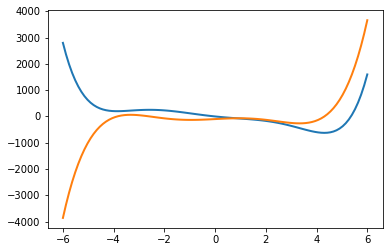

In [4]:
a, b, c, d = 1.0, -20.0, 50.0, -100.0
pu = [1/6 * a, 0.0, 1/4 * b, 0.0, 1/2 * c, d, 0.0];
p = np.polyder(pu);

xv = np.linspace(-6.0, 6.0, 100)

plt.figure();
plt.plot(xv, np.polyval(pu, xv), linewidth=2);
plt.plot(xv, np.polyval(p, xv), linewidth=2);
plt.show();

In [5]:
# x = newton_raphson_poly(p, 10)

In [6]:
L = 1.0
alpha = p[0] * L
pn = p / p[0]
roots = np.roots(pn)
pord = len(roots)

# Note: Roots must be unique?!

C = np.zeros([pord, pord], dtype=np.cdouble)
for i in range(len(roots)):
    pprod = [1]
    for j in range(len(roots)):
        if i != j:
            pprod = np.polymul(pprod, [1, -roots[j]])
    #print(pprod)
    C[0:,i] = pprod[0:]
exps = npla.solve(C, np.array((pord-1)*[0.]+[1.]))

# # test
# pprod = [0]
# for r,e in zip(roots, exps):
#     pdiv, pdiv_r = np.polydiv(p, [1.0, -r])
#     pdiv = e * pdiv
#     pprod = np.polyadd(pprod, pdiv)
# print("error = ", np.sum(np.abs(pprod-np.array((pord-1)*[0.]+[1.]))))

print("roots = \n", np.transpose([roots]))
print("exponents = \n", np.transpose([exps]))

roots = 
 [[ 4.30772833+0.j        ]
 [-3.86126302+0.j        ]
 [-2.57877626+0.j        ]
 [ 1.06615548+1.09300904j]
 [ 1.06615548-1.09300904j]]
exponents = 
 [[ 0.00151899+8.22285184e-18j]
 [ 0.00374696+2.42008375e-17j]
 [-0.00781941-1.14118465e-17j]
 [ 0.00127673+6.84453213e-03j]
 [ 0.00127673-6.84453213e-03j]]


In [20]:
m0 = -1.0

tv = np.linspace(0.0, 0.06, 16);
mv = np.zeros(tv.shape);

tol = 1.0e-10

m = m0
for i in range(len(tv)):
    m = zero_finder_sv (m, m0, roots, exps, tv[i], alpha, tol=tol)
    mv[i] = m

Warning! Case not accounted.
num iter =  0
num iter =  38
num iter =  42
num iter =  38
num iter =  37
num iter =  37
num iter =  36
num iter =  36
num iter =  35
num iter =  35
num iter =  34
num iter =  32
num iter =  30
num iter =  26
num iter =  22
num iter =  18


/home/gmoore/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


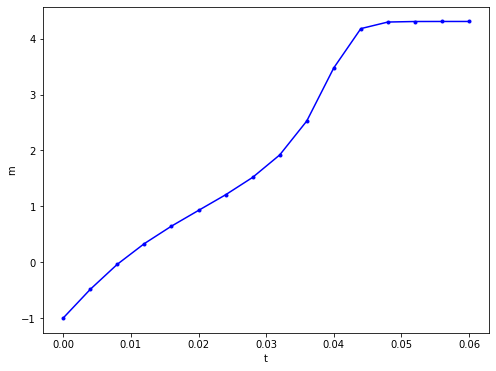

In [21]:
plt.figure(figsize=[8,6]);
plt.plot(tv, mv, 'b.-');
plt.ylabel('m');
plt.xlabel('t');
plt.show();

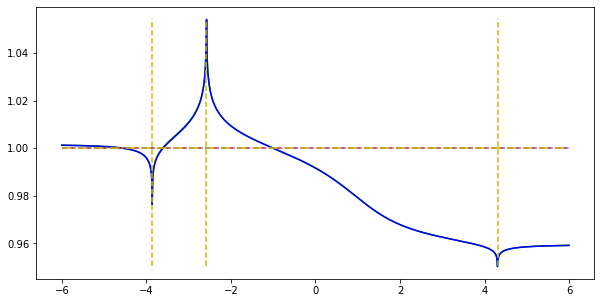

In [9]:
t = 0.0
m = np.linspace(-6.0, 6.0, 1000)
y = (sv_lhs (m, m0, roots, exps))

plt.figure(figsize=[10,5]);
plt.plot(m, np.abs(y), 'g-')
#plt.plot(m, np.imag(y), 'r-')
plt.plot(m, np.real(y), 'b-')

plt.plot(m, np.exp(-alpha*t) + 0.0*m, 'm--')
#plt.plot(m, -alpha*t + 0.0*m, 'm--')
plt.plot(m, 1.0 + 0.0*m, 'y-.')

for r in roots:
    if np.abs(np.imag(r)) < 1e-12:
        plt.plot(np.real(r) + 0.0*m, 
                 np.linspace(np.min(np.real(y)), np.max(np.real(y)), len(m)), 'y--')

plt.show()

# yp = sv_lhs_deriv (m, m0, roots, exps)

# plt.figure(figsize=[10,5]);
# plt.plot(m, np.real(yp), 'b-')
# plt.plot(m, np.imag(yp), 'r.')
# #plt.plot(m, np.abs(yp), 'g.')
# plt.show()